In [1]:
 !pip install pytorch-tabnet
!pip install wget
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=5e3e75b65408e7ff51cf1cad5ed7cf0189a4d5138a547b542cd7b74712b59b44
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Download ForestCoverType dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    


# Load data and split
Same split as in original paper

In [4]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [5]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [7]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [ ]:
tabnet_forest_covertype = tabnet_model.TabNet(
      columns=data_helper_covertype.get_columns(),
      num_features=data_helper_covertype.num_features,
      feature_dim=128,
      output_dim=64,
      num_decision_steps=6,
      relaxation_factor=1.5,
      batch_momentum=0.7,
      virtual_batch_size=512,
      num_classes=data_helper_covertype.num_classes)

# Network parameters

In [18]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=6,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.7, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


# Training

In [19]:
np.random.seed(10)

In [20]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [25]:
max_epochs = 250 if not os.getenv("CI", False) else 2

In [26]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=512
) 

epoch 0  | loss: 0.61518 | train_accuracy: 0.76091 | valid_accuracy: 0.75871 |  0:00:12s
epoch 1  | loss: 0.52118 | train_accuracy: 0.7735  | valid_accuracy: 0.77139 |  0:00:25s
epoch 2  | loss: 0.48751 | train_accuracy: 0.78832 | valid_accuracy: 0.78555 |  0:00:38s
epoch 3  | loss: 0.46176 | train_accuracy: 0.80137 | valid_accuracy: 0.79883 |  0:00:51s
epoch 4  | loss: 0.45153 | train_accuracy: 0.80869 | valid_accuracy: 0.80626 |  0:01:04s
epoch 5  | loss: 0.43075 | train_accuracy: 0.82145 | valid_accuracy: 0.81718 |  0:01:17s
epoch 6  | loss: 0.41698 | train_accuracy: 0.81791 | valid_accuracy: 0.81479 |  0:01:29s
epoch 7  | loss: 0.40627 | train_accuracy: 0.83095 | valid_accuracy: 0.82644 |  0:01:42s
epoch 8  | loss: 0.38913 | train_accuracy: 0.83419 | valid_accuracy: 0.8296  |  0:01:55s
epoch 9  | loss: 0.39491 | train_accuracy: 0.84208 | valid_accuracy: 0.83874 |  0:02:08s
epoch 10 | loss: 0.36987 | train_accuracy: 0.85499 | valid_accuracy: 0.85075 |  0:02:20s
epoch 11 | loss: 0.35

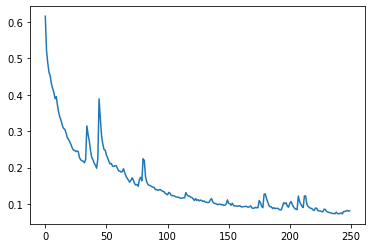

In [27]:
# plot losses
plt.plot(clf.history['loss'])

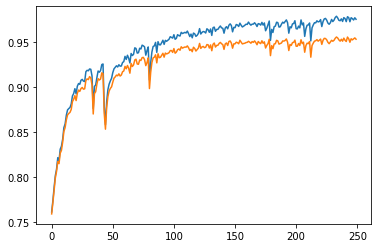

In [28]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions


In [44]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.9560595596920038
FINAL TEST SCORE FOR forest-cover-type : 0.9573591043260501


In [30]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9573591043260501


# Save and load Model

In [38]:
from scipy.stats import norm
import numpy as np

In [45]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [46]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

Device used : cuda
Device used : cuda


In [47]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9573591043260501


In [48]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [49]:
clf.feature_importances_

array([0.02706155, 0.00224204, 0.        , 0.0169078 , 0.00702301,
       0.09004384, 0.00543241, 0.        , 0.0081443 , 0.03452983,
       0.02028738, 0.00762809, 0.04146721, 0.06607267, 0.00256568,
       0.03350473, 0.00235232, 0.02343026, 0.01150907, 0.01723413,
       0.00218536, 0.00756994, 0.0090012 , 0.00111894, 0.00485791,
       0.02115196, 0.00534118, 0.0359652 , 0.02299261, 0.00048725,
       0.00717472, 0.02647674, 0.048271  , 0.03296242, 0.        ,
       0.00962044, 0.        , 0.03283985, 0.03855981, 0.00317525,
       0.00072577, 0.10370407, 0.01681898, 0.01256456, 0.00247763,
       0.        , 0.03028697, 0.01698952, 0.00381157, 0.00322042,
       0.02578737, 0.00842081, 0.02821594, 0.0197883 ])

# Local explainability and masks

In [50]:
explain_matrix, masks = clf.explain(X_test)

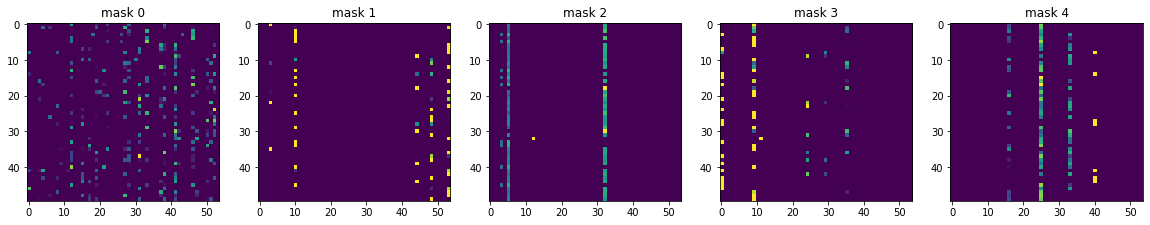

In [51]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [52]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

[0]	validation_0-merror:0.220102
Will train until validation_0-merror hasn't improved in 40 rounds.
[10]	validation_0-merror:0.195292
[20]	validation_0-merror:0.184288
[30]	validation_0-merror:0.17753
[40]	validation_0-merror:0.170727
[50]	validation_0-merror:0.162376
[60]	validation_0-merror:0.15656
[70]	validation_0-merror:0.151268
[80]	validation_0-merror:0.14644
[90]	validation_0-merror:0.141348
[100]	validation_0-merror:0.136733
[110]	validation_0-merror:0.132015
[120]	validation_0-merror:0.127006
[130]	validation_0-merror:0.123005
[140]	validation_0-merror:0.119055
[150]	validation_0-merror:0.11464
[160]	validation_0-merror:0.110348
[170]	validation_0-merror:0.107198
[180]	validation_0-merror:0.103397
[190]	validation_0-merror:0.099834
[200]	validation_0-merror:0.097485
[210]	validation_0-merror:0.093922
[220]	validation_0-merror:0.091353
[230]	validation_0-merror:0.089004
[240]	validation_0-merror:0.086467
[250]	validation_0-merror:0.084066
[260]	validation_0-merror:0.081427
[27

In [ ]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)